In [1]:
from utils import load_data, check_gpu, check_dir
from clean_session import preprocess_sessions
import pandas as pd
import numpy as np
from tqdm import tqdm
import gc
import catboost as cat
import matplotlib.pyplot as plt
from clean_session import preprocess_sessions
from manual_encoding import action_encoding, click_view_encoding, meta_encoding
from hotel2vec import hotel2vec

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
%%time
train = load_data('train')
train = train[(train.action_type == 'clickout item') & (train.impressions.notna())]

In [3]:
train = load_data('train', usecols=['session_id'])
s = train.groupby('session_id')['session_id'].size()

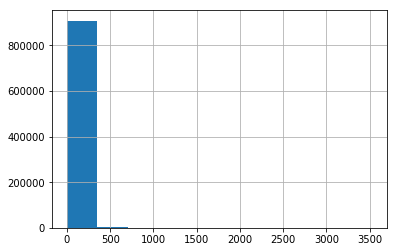

In [6]:
s.hist()

In [7]:
s.head()

session_id
00000510f1adc    1
00003f3b20954    1
000056cd97ce2    4
000066611146f    3
00008c1f39c46    4
Name: session_id, dtype: int64

In [9]:
pd.value_counts(s.values, normalize=True).cumsum()

1       0.217707
2       0.358454
3       0.461227
4       0.531149
5       0.585152
6       0.624020
7       0.654681
8       0.679220
9       0.698987
10      0.715871
11      0.730136
12      0.742767
13      0.754041
14      0.764296
15      0.773667
16      0.782378
17      0.790500
18      0.797930
19      0.805094
20      0.811695
21      0.817959
22      0.823752
23      0.829315
24      0.834680
25      0.839752
26      0.844529
33      0.849059
27      0.853566
28      0.857991
32      0.862348
          ...   
772     0.999968
1110    0.999969
1282    0.999970
860     0.999971
662     0.999973
663     0.999974
863     0.999975
1107    0.999976
1887    0.999977
864     0.999978
2816    0.999979
1105    0.999980
593     0.999981
1378    0.999982
879     0.999984
2202    0.999985
591     0.999986
767     0.999987
1102    0.999988
766     0.999989
2127    0.999990
870     0.999991
668     0.999992
1277    0.999993
765     0.999995
1383    0.999996
1611    0.999997
1098    0.9999

In [3]:
train.shape

(1586586, 12)

In [ ]:
click_counts = train.reference.value_counts()
click_counts.head()

In [ ]:
click_counts.hist(bins=100)

In [ ]:
train['cfs'] = train.current_filters.str.split('|')

In [ ]:
all_cfs = train.cfs.dropna().values
all_cfs = [j for i in all_cfs for j in i]

In [ ]:
pd.value_counts(all_cfs).head()

In [ ]:
cf_df = pd.DataFrame({'filters': list(set(all_cfs))})

In [ ]:
cf_df[cf_df.filters.str.contains(r'\bsort', case=False)]

In [ ]:
cf_df[cf_df.filters.str.contains(r'focus', case=False)]

In [ ]:
cf_df.filters.values

In [8]:
def explode(df):
    impressions = df['impressions'].values.tolist()
    rs = [len(r) for r in impressions]
    # locations
    inds = np.concatenate([np.arange(i, dtype=int) for i in rs])
    # the rest cols
    rest_cols = [c for c in df.columns if c not in ['impressions']]
    rest_arr = np.repeat(df[rest_cols].values, rs, axis=0)
    # create dataframe to host the exploded
    exploded = pd.DataFrame(np.column_stack((rest_arr, np.concatenate(impressions))),
                            columns=rest_cols + ['impression'])
    exploded['impression'] = exploded['impression'].astype(int)
    return exploded

def shrink(df):
    cols = [c for c in t.columns if c not in ['impression']]
    return df.groupby(cols)['impression'].apply(list).reset_index()

In [10]:
train['impressions'] = train['impressions'].str.split('|')
t = explode(train[:100])

[['3400638', '1253714', '3367857', '5100540', '1088584', '666916', '54833', '2922310', '9711560', '109038', '666856', '10077318', '1431482', '129343', '6339822', '6806806', '1041528', '109013', '3909420', '55088', '3095758', '109018', '54885', '1257342', '2595006'], ['55109', '129343', '54824', '2297972', '109014', '1257342', '1031578', '109018', '1332971', '666916', '54833', '54885', '2237222', '10077318', '1166793', '9132132', '1474297', '3909420', '6622154', '55091', '8444418', '54804', '2050977', '666936', '55088'], ['2795374', '5582964', '1088390', '2781070', '1258068', '1271962', '3184892', '148884', '3528776', '107183', '5156744', '107048', '1907333', '3370484', '6003326', '8436316', '9025316', '125181', '3861490', '131257', '4415954', '107162', '3143352', '6652864', '8118684'], ['12693', '46363', '81657', '18448', '47687', '152913', '18417', '927627', '4147572', '819616', '18380', '47333', '18425', '1255377', '4043482', '1032816', '18388', '1216900', '106471', '106567', '12667'

In [12]:
t.head()

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,prices,impression,impression_loc
0,00RL8Z82B2Z1,aff3928535f48,1541037543,14,clickout item,109038,AU,"Sydney, Australia",mobile,NaN,95|66|501|112|95|100|101|72|82|56|56|143|70|25...,3400638,0
1,00RL8Z82B2Z1,aff3928535f48,1541037543,14,clickout item,109038,AU,"Sydney, Australia",mobile,NaN,95|66|501|112|95|100|101|72|82|56|56|143|70|25...,1253714,1
2,00RL8Z82B2Z1,aff3928535f48,1541037543,14,clickout item,109038,AU,"Sydney, Australia",mobile,NaN,95|66|501|112|95|100|101|72|82|56|56|143|70|25...,3367857,2
3,00RL8Z82B2Z1,aff3928535f48,1541037543,14,clickout item,109038,AU,"Sydney, Australia",mobile,NaN,95|66|501|112|95|100|101|72|82|56|56|143|70|25...,5100540,3
4,00RL8Z82B2Z1,aff3928535f48,1541037543,14,clickout item,109038,AU,"Sydney, Australia",mobile,NaN,95|66|501|112|95|100|101|72|82|56|56|143|70|25...,1088584,4


In [15]:
t[t.step==16].head()

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,prices,impression,impression_loc
25,00RL8Z82B2Z1,aff3928535f48,1541038485,16,clickout item,1257342,AU,"Sydney, Australia",mobile,NaN,162|25|150|143|101|49|118|131|18|100|101|143|5...,55109,0
26,00RL8Z82B2Z1,aff3928535f48,1541038485,16,clickout item,1257342,AU,"Sydney, Australia",mobile,NaN,162|25|150|143|101|49|118|131|18|100|101|143|5...,129343,1
27,00RL8Z82B2Z1,aff3928535f48,1541038485,16,clickout item,1257342,AU,"Sydney, Australia",mobile,NaN,162|25|150|143|101|49|118|131|18|100|101|143|5...,54824,2
28,00RL8Z82B2Z1,aff3928535f48,1541038485,16,clickout item,1257342,AU,"Sydney, Australia",mobile,NaN,162|25|150|143|101|49|118|131|18|100|101|143|5...,2297972,3
29,00RL8Z82B2Z1,aff3928535f48,1541038485,16,clickout item,1257342,AU,"Sydney, Australia",mobile,NaN,162|25|150|143|101|49|118|131|18|100|101|143|5...,109014,4


In [13]:
train.shape

(1586586, 12)

In [14]:
train.head()

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
13,00RL8Z82B2Z1,aff3928535f48,1541037543,14,clickout item,109038,AU,"Sydney, Australia",mobile,NaN,"[3400638, 1253714, 3367857, 5100540, 1088584, ...",95|66|501|112|95|100|101|72|82|56|56|143|70|25...
15,00RL8Z82B2Z1,aff3928535f48,1541038485,16,clickout item,1257342,AU,"Sydney, Australia",mobile,NaN,"[55109, 129343, 54824, 2297972, 109014, 125734...",162|25|150|143|101|49|118|131|18|100|101|143|5...
115,02SRUT1NQYH1,3599a6f709eab,1541063864,35,clickout item,2795374,FI,"Krakow, Poland",mobile,NaN,"[2795374, 5582964, 1088390, 2781070, 1258068, ...",64|54|36|121|76|81|92|40|73|52|98|104|56|414|6...
121,03K8AXBL4BX2,ec139e10b9238,1541100322,6,clickout item,1032816,UK,"London, United Kingdom",desktop,NaN,"[12693, 46363, 81657, 18448, 47687, 152913, 18...",104|92|100|103|102|104|72|85|81|75|107|86|98|8...
122,03K8AXBL4BX2,ec139e10b9238,1541100652,7,clickout item,1032816,UK,"London, United Kingdom",desktop,NaN,"[12693, 46363, 81657, 18448, 47687, 152913, 18...",104|92|100|103|102|104|72|85|81|75|107|86|98|8...


In [17]:
t.head()

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,prices,impression,impression_loc
0,00RL8Z82B2Z1,aff3928535f48,1541037543,14,clickout item,109038,AU,"Sydney, Australia",mobile,NaN,95|66|501|112|95|100|101|72|82|56|56|143|70|25...,3400638,0
1,00RL8Z82B2Z1,aff3928535f48,1541037543,14,clickout item,109038,AU,"Sydney, Australia",mobile,NaN,95|66|501|112|95|100|101|72|82|56|56|143|70|25...,1253714,1
2,00RL8Z82B2Z1,aff3928535f48,1541037543,14,clickout item,109038,AU,"Sydney, Australia",mobile,NaN,95|66|501|112|95|100|101|72|82|56|56|143|70|25...,3367857,2
3,00RL8Z82B2Z1,aff3928535f48,1541037543,14,clickout item,109038,AU,"Sydney, Australia",mobile,NaN,95|66|501|112|95|100|101|72|82|56|56|143|70|25...,5100540,3
4,00RL8Z82B2Z1,aff3928535f48,1541037543,14,clickout item,109038,AU,"Sydney, Australia",mobile,NaN,95|66|501|112|95|100|101|72|82|56|56|143|70|25...,1088584,4


In [27]:
cols = [c for c in t.columns if c not in ['impression', 'impression_loc']]
cols

['user_id',
 'session_id',
 'timestamp',
 'step',
 'action_type',
 'reference',
 'platform',
 'city',
 'device',
 'current_filters',
 'prices']

In [29]:
t.groupby(cols)['impression'].apply(list).reset_index()

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,prices,impression
0,03P4VFKK12UO,325fafb5fa450,1541107500,54,clickout item,65685,US,"Bakersfield, USA",desktop,Very Good Rating|5 Star|4 Star|Hotel|Motel|Res...,178|104|110|94|57|96|46|61|48|35|50|38|59|44|5...,"[1306936, 56482, 2842358, 6881276, 65685, 6325..."
1,03P4VFKK12UO,325fafb5fa450,1541107538,55,clickout item,1320460,US,"Bakersfield, USA",desktop,Very Good Rating|5 Star|4 Star|Hotel|Motel|Res...,178|104|110|94|57|96|46|61|48|35|50|38|59|44|5...,"[1306936, 56482, 2842358, 6881276, 65685, 6325..."
2,0NA8E4AD2VY7,336d9a46b826f,1541078452,91,clickout item,1091180,RU,"Yekaterinburg, Russia",desktop,Free WiFi (Combined)|Breakfast Included,44|87|30|62|73|59|85|43|68|31|35|48|59|56|42|1...,"[1045290, 3135752, 1372961, 1369024, 3384308, ..."
3,0NA8E4AD2VY7,336d9a46b826f,1541078493,92,clickout item,1091180,RU,"Yekaterinburg, Russia",desktop,Free WiFi (Combined)|Breakfast Included,44|87|30|62|73|59|85|43|68|31|35|48|59|56|42|1...,"[1045290, 3135752, 1372961, 1369024, 3384308, ..."
4,0NA8E4AD2VY7,336d9a46b826f,1541079107,112,clickout item,3404929,RU,"Yekaterinburg, Russia",desktop,Free WiFi (Combined)|Breakfast Included,44|87|30|62|73|59|85|43|68|31|35|48|59|56|42|1...,"[1045290, 3135752, 1372961, 1369024, 3384308, ..."
5,0O1CTEP95YKQ,af793494b5f84,1541113474,19,clickout item,63051,CO,"Las Vegas, USA",mobile,Breakfast Included|Sort by Price,59|66|78|86|87|90|90|92|93|98|99|100|106|108|1...,"[69086, 8533, 925367, 58949, 61049, 8581, 8517..."
6,0O1CTEP95YKQ,af793494b5f84,1541113509,20,clickout item,2851635,CO,"Las Vegas, USA",mobile,Breakfast Included|Sort by Price,59|66|78|86|87|90|90|92|93|98|99|100|106|108|1...,"[69086, 8533, 925367, 58949, 61049, 8581, 8517..."
7,0O1CTEP95YKQ,af793494b5f84,1541113537,22,clickout item,8602,CO,"Las Vegas, USA",mobile,Breakfast Included|Sort by Price,59|66|78|86|87|90|90|92|93|98|99|100|106|108|1...,"[69086, 8533, 925367, 58949, 61049, 8581, 8517..."
8,0Q3605EUBZG3,641a409c90fac,1541095202,44,clickout item,4041114,BR,"Rio de Janeiro, Brazil",mobile,Best Value,72|29|122|98|187|86|66|124|112|104|118|107|146...,"[2303306, 4041114, 5830856, 111534, 109353, 57..."
9,0Q3605EUBZG3,641a409c90fac,1541095238,47,clickout item,9112068,BR,"Rio de Janeiro, Brazil",mobile,Best Value,70|71|71|72|75|75|78|78|80|80|80|81|81|83|84|8...,"[5016850, 2068758, 1771981, 2303306, 2733700, ..."


### city

In [ ]:
# unique city, platform, reference counts (regardless of session length)
city_counts = train_last.city.value_counts()
print(city_counts.shape)
city_counts.head()

In [ ]:
city_counts.hist(bins=100)

In [ ]:
city_counts_cs = city_counts.cumsum()/(city_counts.sum())
city_counts_cs.head()

In [ ]:
th = 0.9

In [ ]:
above_th = city_counts_cs[city_counts_cs<th]
common_cities = above_th.index.values
print(above_th.shape)
above_th.head()

In [ ]:
below_th = city_counts_cs[city_counts_cs>=th]
rare_cities = below_th.index.values
print(below_th.shape)
below_th.head()

In [ ]:
train_last.city.nunique()

In [ ]:
city_counts_cs.shape

### the distribution of number of city appearence

In [ ]:
pd.value_counts(city_counts.values).head()

In [ ]:
pd.value_counts(city_counts.values, normalize=True).cumsum()[:10]

In [ ]:
# unique value counts of city counts
len(set(city_counts.values))

majority (75% of unique city only appeared less than 10 times), one way to alleivate this is 

    1) bin rarely occursing cities to one
    2) use or add country info

### impression list length dist

In [ ]:
train_last['imp_list'] = train_last.impressions.str.split('|')

In [ ]:
imp_len = train_last.imp_list.str.len()
imp_len.value_counts().head()

In [ ]:
imp_len.value_counts().tail()

In [ ]:
train_last[train_last.imp_list.str.len()==1].city.isin(below_th.index).sum()

In [ ]:
train_last[train_last.imp_list.str.len()==2].city.isin(below_th.index).sum()

### number of item_ids from common cities 

In [ ]:
common_cities

In [ ]:
all_uniqe_item_ids = train_last.imp_list.values
all_uniqe_item_ids = [j for i in all_uniqe_item_ids for j in i]

In [ ]:
all_item_id_counts = pd.value_counts(all_uniqe_item_ids)

In [ ]:
all_item_id_counts.head()

In [ ]:
_ = all_item_id_counts.hist()

In [ ]:
all_item_id_counts_cs = all_item_id_counts.cumsum()/(all_item_id_counts.sum())

In [ ]:
above_th_item = all_item_id_counts_cs[all_item_id_counts_cs<th]
print(above_th_item.shape)

In [ ]:
below_th_item = all_item_id_counts_cs[all_item_id_counts_cs>=th]
print(below_th_item.shape)

In [ ]:
all_item_id_counts.shape

In [ ]:
item_id_appearence_counts = pd.value_counts(all_item_id_counts.values)
item_id_appearence_counts.head()

In [ ]:
item_id_appearence_counts.tail()

In [ ]:
(item_id_appearence_counts.cumsum()/(item_id_appearence_counts.sum())).head()

In [ ]:
# now look at the item_ids from only common cities
train_common = train_last[train_last.city.isin(common_cities)].reset_index(drop=True)
common_item_ids = train_common.imp_list.values
common_item_ids = [j for i in common_item_ids for j in i]

In [ ]:
common_item_ids_counts = pd.value_counts(common_item_ids)

In [ ]:
common_item_ids_counts.head()

In [ ]:
common_item_ids_counts.hist()

In [ ]:
common_appearence = pd.value_counts(common_item_ids_counts.values)
(common_appearence.cumsum()/(common_appearence.sum())).head()

### intersection between impression list of different citys

In [ ]:
cols = [c for c in train_last.columns if c != 'step']
train_last_dd = train_last.drop_duplicates(subset=cols)

In [ ]:
train_last_dd.head()

In [ ]:
city_impressions = train_last_dd.groupby('city')['impressions'].apply(list).reset_index()

In [ ]:
city_impressions.head()

In [ ]:
def unroll(x):
    splits = [i.split('|') for i in x]
    return [j for i in splits for j in i]
city_impressions['imps'] = city_impressions.impressions.apply(unroll)

In [ ]:
city_impressions.shape

In [ ]:
city_impressions['uimps'] = city_impressions.imps.apply(lambda x: list(set(x)))

In [ ]:
city_impressions.head()

In [ ]:
# inters = []
# print(city_impressions.shape[0])
# for i in range(city_impressions.shape[0]):
#     city_i = city_impressions.loc[i, 'city']
# #     print(f'{city_i} | {i}')#, end='\r')
#     for j in range(i+1, city_impressions.shape[0]):
#         nint = (city_i, city_impressions.loc[i+1, 'city']), len(set(city_impressions.loc[i, 'uimps']).intersection(city_impressions.loc[i+1, 'uimps']))
#         if nint[1] != 0:
#             if nint not in inters:
#                 print(nint)
#                 inters.append(nint)
        

In [ ]:
# (('100 Mile House, Canada', '100 Mile Ranch, Canada'), 8)
# (('Aci Castello, Italy', 'Acireale, Italy'), 30)
# (('Acireale, Italy', 'Acitrezza, Italy'), 16)
# (('Addo Elephant National Park, South Africa', 'Addo, South Africa'), 30)
# (('Ahrenshagen-Daskow, Germany', 'Ahrenshoop, Germany'), 18)
# (('Aime, France', 'Aime-La Plagne, France'), 7)
# (('Akiruno, Japan', 'Akishima, Japan'), 40)
# (('Alhaurín de la Torre, Spain', 'Alhaurín el Grande, Spain'), 4)
# (('Almelo, Netherlands', 'Almen, Netherlands'), 6)
# (('Almeria, Spain', 'Almerimar, Spain'), 12)
# (('Alto Paraíso de Goiás, Brazil', 'Alto Paraíso, Brazil'), 25)
# (('Alupka, Crimea', 'Alushta, Crimea'), 11)
# (('Amstelveen, Netherlands', 'Amsterdam, Netherlands'), 141)
# (('Annecy, France', 'Annecy-le-Vieux, France'), 107)
# (('Arnedillo, Spain', 'Arnedo, Spain'), 15)
# (('Arr. Chicoutimi, Canada', 'Arr. Jonquière, Canada'), 28)
# (('Audinghen, France', 'Audresselles, France'), 28)
# (('Ayampe, Ecuador', 'Ayangue, Ecuador'), 2)
# (('Ayr, United Kingdom', 'Ayrshire, United Kingdom'), 5)
# (('Baarle-Hertog, Belgium', 'Baarle-Nassau, Netherlands'), 4)
# (('Bacolod City, Philippines', 'Bacolod, Philippines'), 33)
# (('Badacsony, Hungary', 'Badacsonytomaj, Hungary'), 19)
# (('Badacsonytomaj, Hungary', 'Badacsonyörs, Hungary'), 19)
# (('Baia Mare, Romania', 'Baia Sprie, Romania'), 39)
# (('Balaruc les Bains, France', 'Balaruc-le-Vieux, France'), 26)
# (('Balatonakarattya, Hungary', 'Balatonalmádi, Hungary'), 13)
# (('Balatonboglár, Hungary', 'Balatonfenyves, Hungary'), 10)
# (('Balatonföldvár, Hungary', 'Balatonfüred, Hungary'), 49)
# (('Balatonlelle, Hungary', 'Balatonmáriafürdő, Hungary'), 3)
# (('Ballymena, United Kingdom', 'Ballymoney, United Kingdom'), 3)
# (('Batehaven, Australia', 'Batemans Bay, Australia'), 35)
# (('Batu Aji, Indonesia', 'Batu Ampar, Indonesia'), 23)

### countries

In [ ]:
countries = train_last.city.str.split(',').str[1]

In [ ]:
countries_counts = countries.value_counts()
print(countries_counts.shape)
countries_counts.head()

In [ ]:
countries_counts.hist(bins=100)

In [ ]:
pd.value_counts(countries_counts.values).head()

In [ ]:
pd.value_counts(countries_counts.values)[::-1].head()

## now look at test

In [ ]:
%%time
test = load_data('test')

In [ ]:
%%time
sub = load_data('submission_popular')

In [ ]:
test_sub = test[test.session_id.isin(sub.session_id)].reset_index(drop=True)

In [ ]:
test_sub['nimp'] = test_sub.impressions.str.split('|').str.len()

In [ ]:
# sub[sub.session_id.isin(test_sub[test_sub.nimp==1].session_id)]

In [ ]:
test_sub_last = test_sub.groupby('session_id').last().reset_index() # this may not be ideal

In [ ]:
test_sub_last.shape

In [ ]:
test_sub_city_counts = test_sub_last.city.value_counts()
test_sub_city_counts.head()

In [ ]:
test_sub_city_counts_cs = test_sub_city_counts.cumsum()/(test_sub_city_counts.sum())
test_sub_city_counts_cs.head()

In [ ]:
print(th)
test_sub_above_th = test_sub_city_counts_cs[test_sub_city_counts_cs<th]
print(test_sub_above_th.shape)
common_test_sub_cities = test_sub_above_th.index.values

number of common cities intersections with trains

In [ ]:
len(set(common_test_sub_cities).intersection(common_cities))

number of impression list with len 1

In [ ]:
test_sub_last['imp_list'] = test_sub_last.impressions.str.split('|')

In [ ]:
test_sub_imp_len = test_sub_last.imp_list.str.len()

In [ ]:
test_sub_imp_len.value_counts()

In [ ]:
866/test_sub_last.shape[0]*100

In [ ]:
# test_sub_last[~test_sub_last.city.isin(common_test_sub_cities)].imp_list.str.len().value_counts()

### platform

In [ ]:
platfrom_counts = train_last.platform.value_counts()
platfrom_counts.head()

In [ ]:
platfrom_counts.hist(bins=50)

In [ ]:
np.log1p(platfrom_counts).hist(bins=50)

In [ ]:
platfrom_counts.shape

In [ ]:
train.platform.nunique()

In [ ]:
(55)**(1/4)

In [ ]:
train.city.nunique()

In [ ]:
30519**(1/4)